<font size=5> This document includes or references data provided by J.P. Morgan. </font>

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

In [14]:
# Loads full dataset
JPfraud_full = pd.read_csv("../data/fraud_payment_data")
JPfraud_full

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498173,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498174,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498175,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [15]:
# Removing $0 transactions, which contain no fraud labels
JPfraud = JPfraud_full[JPfraud_full.USD_amount > 0].reset_index(level=0,drop=True)

In [16]:
# Converting strings of timestamps to datetime objects
JPfraud['timestamp'] = pd.to_datetime(JPfraud['Time_step'],format='%Y-%m-%d %H:%M:%S')
JPfraud = JPfraud.drop(columns=['Time_step'])

In [17]:
# Gathering the number of fraud and non-fraud transactions for each transaction type
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))
non_fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()
    non_fraud_number[i] = len(JPfraud[JPfraud.Label == 0].loc[JPfraud.Transaction_Type == trans])

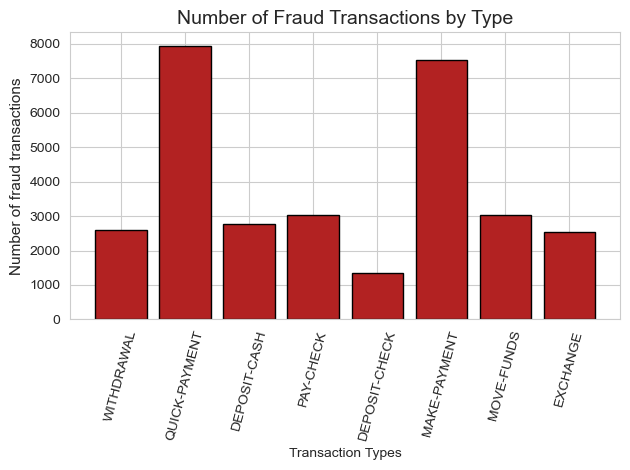

In [18]:
plt.figure()

plt.bar(trans_types, fraud_number, edgecolor='black', color='firebrick')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of fraud transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)
plt.title('Number of Fraud Transactions by Type',fontsize=14)
plt.tight_layout()
plt.savefig('Fraud_number_vs_transaction_types.png')
plt.show()

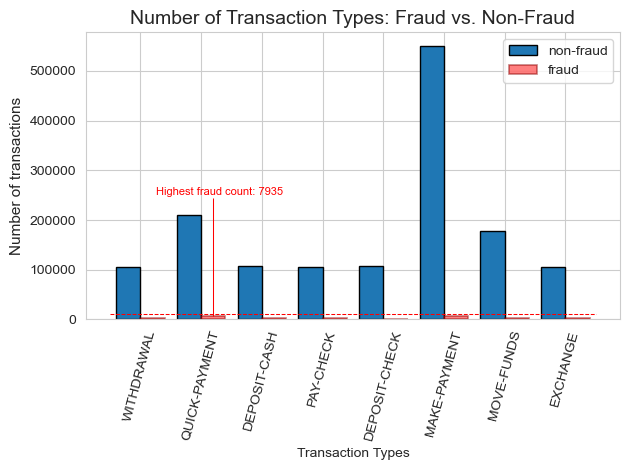

In [19]:
plt.figure()

w = 0.4

plt.bar(np.arange(len(trans_types))-w/2, non_fraud_number, label='non-fraud', edgecolor='black', width=w)
plt.bar(np.arange(len(trans_types))+w/2, fraud_number, alpha = 0.5, color='red', width=w,
        label='fraud', edgecolor='darkred', linewidth=1.2)
plt.hlines(y=fraud_number[1]+2038, xmin=-0.5, xmax=len(trans_types)-0.5,
           linewidth=0.75, color='red', linestyle='--')
plt.vlines(x=1.2, ymin=fraud_number[1], ymax=245000,
           linewidth=0.75, color='red', linestyle='-')
plt.text(0.25,250000, 'Highest fraud count: 7935', fontsize=8, color='red')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)), trans_types, rotation=75)
plt.title('Number of Transaction Types: Fraud vs. Non-Fraud',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('fraud_and_non-fraud_vs_transaction_types.png')
plt.show()

In [20]:
# Calculates time between previous transaction for each of seller, beneficiary
# (The mask.....etc code sets the sender_time_btwn, bene_time_btwn feature to 0 (of timedelta type)
# for the first occurrence an account appears. NaT's are still placed where a Sender_Account or
# Bene_Account entry is NaN.)

JPfraud['sender_time_btwn'] = (JPfraud.groupby('Sender_Account')['timestamp'].diff()
                                      .mask(JPfraud.groupby('Sender_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                              )
JPfraud['bene_time_btwn'] = (JPfraud.groupby('Bene_Account')['timestamp'].diff()
                                    .mask(JPfraud.groupby('Bene_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                            )

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,timestamp,sender_time_btwn,bene_time_btwn
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL,2022-03-15 10:24:00,0 days 00:00:00,NaT
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,2022-03-15 10:24:00,0 days 00:00:00,0 days 00:00:00
2,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,2022-03-15 10:24:00,NaT,0 days 00:00:00
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,2022-03-15 10:24:00,0 days 00:00:00,0 days 00:00:00
4,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,2022-03-15 10:24:00,NaT,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT,2054-09-14 13:17:24,1 days 00:20:00,28 days 06:40:00
1498151,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT,2054-09-15 00:57:24,0 days 12:00:00,6 days 13:30:00
1498152,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT,2054-09-15 01:17:24,0 days 12:00:00,0 days 00:00:00
1498153,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT,2054-09-15 12:57:24,0 days 12:00:00,0 days 12:00:00


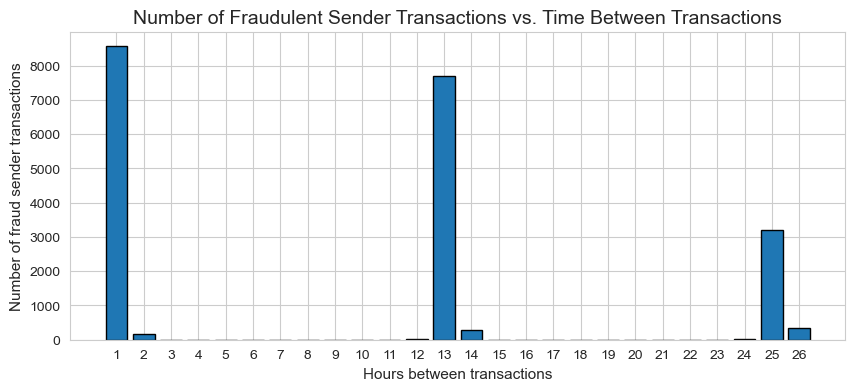

In [21]:
# The below graph plots the number of fraudulent sender transactions against the time between its previous transaction.
# So, if a transaction was made within an hour of a previous transaction, it was counted in the first bar.
# If the transaction was made within 1 and 2 hours after the previous transaction, it was counted in the second
# bar, and so on.

trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    trans_btwn_counts[i] = JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of fraud sender transactions',fontsize=11)
plt.title('Number of Fraudulent Sender Transactions vs. Time Between Transactions',fontsize=14)
plt.xticks(np.arange(26)+1)
plt.savefig('sender_hrs_after_fraud.png')
plt.show()

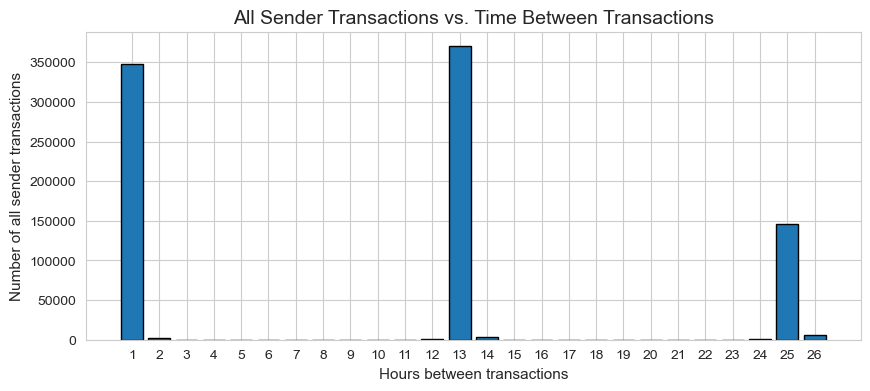

In [22]:
# The below graph plots the number of all sender transactions against the time between its previous transaction.

all_trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    all_trans_btwn_counts[i] = len(JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), all_trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of all sender transactions',fontsize=11)
plt.xticks(np.arange(26)+1)
plt.title('All Sender Transactions vs. Time Between Transactions',fontsize=14)
plt.savefig('sender_hrs_btwn_all_transactions.png')
plt.show()

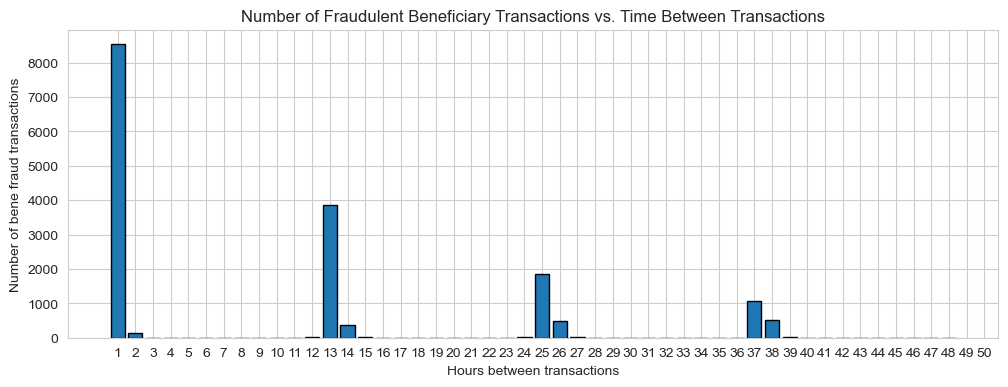

In [23]:
# The below graph plots the number of fraudulent beneficiary transactions against the time between
# its previous transaction.

trans_btwn_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_bene_counts[i] = JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions')
plt.ylabel('Number of bene fraud transactions')
plt.xticks(np.arange(50)+1)
plt.title('Number of Fraudulent Beneficiary Transactions vs. Time Between Transactions')
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()

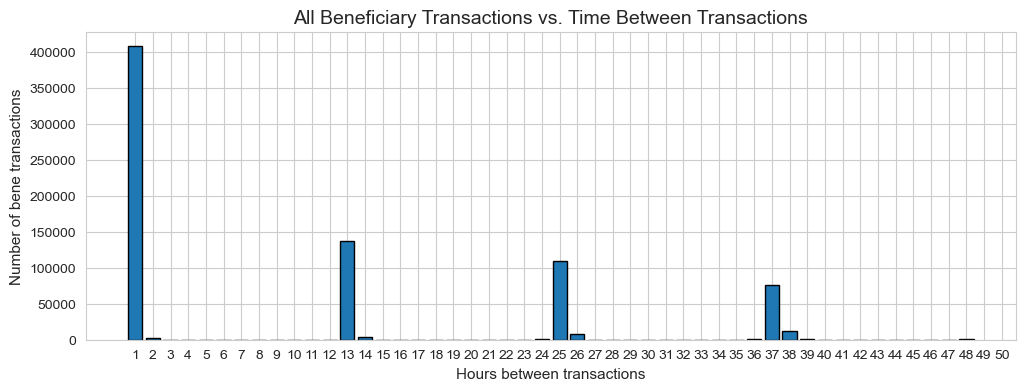

In [24]:
# The below graph plots the number of all beneficiary transactions against the time between its previous transaction.

trans_btwn_all_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_all_bene_counts[i] = len(JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_all_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of bene transactions',fontsize=11)
plt.xticks(np.arange(50)+1)
plt.title('All Beneficiary Transactions vs. Time Between Transactions',fontsize=14)
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()